In [1]:
import pandas as pd
import numpy as np
import random
import os
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, confusion_matrix, classification_report
import pandas as pd
import numpy as np
import subprocess
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from scipy.stats import randint
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
data = pd.read_excel('/Users/rachael/Downloads/train_df_labelled.xlsx')
#the data verified by the third person will be used as the train set finally
file =  data[['content','sentiment']]
file['sentiment'].value_counts()
label_sentiment= file['sentiment'].value_counts()
label_proportions_sentiment= file['sentiment'].value_counts(normalize=True)
print("Counts of each label_sentiment:")
print(label_sentiment)
print("\nProportions of each label_sentiment:")
print(label_proportions_sentiment)

Counts of each label_sentiment:
sentiment
Negative    262
Neither      98
Positive     48
Name: count, dtype: int64

Proportions of each label_sentiment:
sentiment
Negative    0.642157
Neither     0.240196
Positive    0.117647
Name: proportion, dtype: float64


In [3]:
import re
def remove_urls(text):
    # 定义URL的正则表达式
    url_pattern = r'https?://\S+|www\.\S+'
    # 使用re.sub()函数替换URL为空字符串
    no_url_text = re.sub(url_pattern, '', text)
    return no_url_text

def clean_text(text):
    # Remove anything that is not a letter or space
    clean_text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Optional: Convert text to lower case
    clean_text = clean_text.lower()
    return clean_text

#remove stopwords
def remove_stopwords(text, stopwords):
    words = re.findall(r'\b\w+\b', text.lower())
    filtered_words = [word for word in words if word not in stopwords]
    return ' '.join(filtered_words)

dutch_stopwords = ['de', 'en', 'van', 'ik', 'te', 'dat', 
                  'die', 'in', 'een', 'hij', 'het', 'niet', 
                  'zijn', 'is', 'was', 'op', 'aan', 'met', 'als', 
                  'voor', 'had', 'er', 'maar', 'om', 'hem', 'dan', 
                  'zou', 'of', 'wat', 'mijn', 'men', 'dit', 'zo', 
                  'door', 'over', 'ze', 'zich', 'bij', 'ook', 'tot', 
                  'je', 'mij', 'uit', 'der', 'daar', 'haar', 'naar', 
                  'heb', 'hoe', 'heeft', 'hebben', 'deze', 'u', 'want', 
                  'nog', 'zal', 'me', 'zij', 'nu', 'ge', 'geen', 'omdat', 
                  'iets', 'worden', 'toch', 'al', 'waren', 'veel', 'meer', 
                  'doen', 'toen', 'moet', 'ben', 'zonder', 'kan', 'hun', 
                  'dus', 'alles', 'onder', 'ja', 'eens', 'hier', 'wie', 
                  'werd', 'altijd', 'doch', 'wordt', 'wezen', 'kunnen', 
                  'ons', 'zelf', 'tegen', 'na', 'reeds', 'wil', 'kon', 
                  'niets', 'uw', 'iemand', 'geweest', 'andere']

In [4]:
file['content'] = file['content'].apply(remove_urls) 
file['content'] = file['content'].apply(clean_text) 
file['content'] = file['content'].apply(lambda x: remove_stopwords(x, dutch_stopwords))
file['sentiment'] = file['sentiment'].replace({'Positive':0,'Negative': 1, 'Neither': 2})
y = file['sentiment']
X = file['content']

/var/folders/vq/5p2k6x290wzfc5dzz5xm78bm0000gp/T/ipykernel_40027/4109358769.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file['content'] = file['content'].apply(remove_urls)
/var/folders/vq/5p2k6x290wzfc5dzz5xm78bm0000gp/T/ipykernel_40027/4109358769.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file['content'] = file['content'].apply(clean_text)
/var/folders/vq/5p2k6x290wzfc5dzz5xm78bm0000gp/T/ipykernel_40027/4109358769.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

In [5]:
#hyperparameter range
param_dist = {
    'learning_rate': [item/100 for item in range(1, 31)],
    'max_depth': [item for item in range(3, 11)],
    'subsample': [item/10 for item in range(5, 11)],
    'colsample_bytree': [item/10 for item in range(5, 11)],
    'lambda': [item/10 for item in range(0, 11)],
    'alpha': [item/10 for item in range(0, 11)],
}

# Initialize parameters
best_score = 0
best_params = {}

test_scores = []
best_params_list = []
f1_scores = []

In [6]:

# Stratified K-fold for maintaining label distribution, shuffle=True to ensure different data splits each iteration
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
# Loop over each fold
for train_index, test_index in outer_cv.split(X, y):
    trainX, testX = X.iloc[train_index], X.iloc[test_index]
    trainy, testy = y.iloc[train_index], y.iloc[test_index]
    
    # Reset index and prepare data for augmentation
    train_df = pd.concat([trainX.reset_index(drop=True), trainy.reset_index(drop=True)], axis=1)
    test_df = pd.concat([testX.reset_index(drop=True), testy.reset_index(drop=True)], axis=1)
    
    # Standardize text content
    train_df['content'] = train_df['content'].apply(lambda x: ' '.join(x.split()))
    sentiment_0 = train_df[train_df['sentiment'] == 0]
    sentiment_1 = train_df[train_df['sentiment'] == 1]
    sentiment_2 = train_df[train_df['sentiment'] == 2]
    
    # Save sentiment 0 data to file
    output_file_path0 = '/Users/rachael/Desktop/data/sentiment_0.txt'
    with open(output_file_path0, 'w', encoding='utf-8') as f:
        for _, row in sentiment_0.iterrows():
            f.write(f"{row['sentiment']}\t{row['content']}\n")
    subprocess.run([
        'python', '/Users/rachael/Desktop/data/augment.py',
        '--input', output_file_path0,
        '--output', '/Users/rachael/Desktop/data/augmented_train0.txt',
        '--num_aug', '9',
        '--alpha_sr', '0.1',
        '--alpha_rd', '0.1',
        '--alpha_ri', '0.1',
        '--alpha_rs', '0.1'
    ])
    
    # Save sentiment 1 data to file
    output_file_path1 = '/Users/rachael/Desktop/data/sentiment_1.txt'
    with open(output_file_path1, 'w', encoding='utf-8') as f:
        for _, row in sentiment_1.iterrows():
            f.write(f"{row['sentiment']}\t{row['content']}\n")
    subprocess.run([
        'python', '/Users/rachael/Desktop/data/augment.py',
        '--input', output_file_path1,
        '--output', '/Users/rachael/Desktop/data/augmented_train1.txt',
        '--num_aug', '1',
        '--alpha_sr', '0.1',
        '--alpha_rd', '0.1',
        '--alpha_ri', '0.1',
        '--alpha_rs', '0.1'
    ])
    
    # Save sentiment 2 data to file
    output_file_path2 = '/Users/rachael/Desktop/data/sentiment_2.txt'
    with open(output_file_path2, 'w', encoding='utf-8') as f:
        for _, row in sentiment_2.iterrows():
            f.write(f"{row['sentiment']}\t{row['content']}\n")
    subprocess.run([
        'python', '/Users/rachael/Desktop/data/augment.py',
        '--input', output_file_path2,
        '--output', '/Users/rachael/Desktop/data/augmented_train2.txt',
        '--num_aug', '4',
        '--alpha_sr', '0.1',
        '--alpha_rd', '0.1',
        '--alpha_ri', '0.1',
        '--alpha_rs', '0.1'
    ])
    
    # Load augmented data
    file4 = pd.read_csv('/Users/rachael/Desktop/data/augmented_train0.txt', delimiter='\t', header=None, names=['sentiment', 'content'])
    file5 = pd.read_csv('/Users/rachael/Desktop/data/augmented_train1.txt', delimiter='\t', header=None, names=['sentiment', 'content'])
    file6 = pd.read_csv('/Users/rachael/Desktop/data/augmented_train2.txt', delimiter='\t', header=None, names=['sentiment', 'content'])
    augmented_train = pd.concat([file4, file5, file6])
    
    #Extract sentences and labels
    train_sentences = augmented_train['content'].astype(str)
    train_labels = augmented_train['sentiment']
    
    # Transform the training data using TF-IDF
    tfidf_vectorizer = TfidfVectorizer()
    X_train_tfidf = tfidf_vectorizer.fit_transform(train_sentences)
    
    # Extract test sentences and labels
    test_sentences = test_df['content'].astype(str)
    test_labels = test_df['sentiment']
    X_test_tfidf = tfidf_vectorizer.transform(test_sentences) 

   
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    randomized_search = RandomizedSearchCV(
        estimator=xgb,
        param_distributions=param_dist,
        n_iter=100,  # Number of parameter settings that are sampled
        scoring='f1_macro',
        n_jobs=-1,  # Use all available cores
        cv=inner_cv,
        random_state=42,
        verbose=1  # Set verbosity to get more information during the search
    )

    # Fit Randomized Search
    randomized_search.fit(X_train_tfidf, train_labels)

    # Get the best model from Randomized Search
    best_model = randomized_search.best_estimator_
    best_params = randomized_search.best_params_
    best_score = randomized_search.best_score_

    test_predictions = best_model.predict(X_test_tfidf)
    test_f1_score = f1_score(test_labels, test_predictions, average='macro')

    f1_scores.append(test_f1_score)
    best_params_list.append(best_params)

    print(f"Fold F1-score: {test_f1_score}")
    print(f"Best parameters: {best_params}")

mean_f1_score = np.mean(f1_scores)
std_f1_score = np.std(f1_scores)

print(f"Mean F1-score: {mean_f1_score}")
print(f"Standard deviation of F1-scores: {std_f1_score}")
print("Best parameters for each fold:")
for i, params in enumerate(best_params_list):
    print(f"Fold {i + 1}: {params}")


generated augmented sentences with eda for /Users/rachael/Desktop/data/sentiment_0.txt to /Users/rachael/Desktop/data/augmented_train0.txt with num_aug=9
generated augmented sentences with eda for /Users/rachael/Desktop/data/sentiment_1.txt to /Users/rachael/Desktop/data/augmented_train1.txt with num_aug=1
generated augmented sentences with eda for /Users/rachael/Desktop/data/sentiment_2.txt to /Users/rachael/Desktop/data/augmented_train2.txt with num_aug=4
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fold F1-score: 0.4022775624952511
Best parameters: {'subsample': 0.6, 'max_depth': 9, 'learning_rate': 0.19, 'lambda': 0.1, 'colsample_bytree': 0.6, 'alpha': 0.2}
generated augmented sentences with eda for /Users/rachael/Desktop/data/sentiment_0.txt to /Users/rachael/Desktop/data/augmented_train0.txt with num_aug=9
generated augmented sentences with eda for /Users/rachael/Desktop/data/sentiment_1.txt to /Users/rachael/Desktop/data/augmented_train1.txt with num_aug=1
gene

In [6]:
most_common_params = {'subsample': 0.6, 'max_depth': 10, 'learning_rate': 0.3, 'lambda': 0.9, 'colsample_bytree': 0.8, 'alpha': 0.2}


In [7]:
#train the entire model 
file = pd.read_excel('/Users/rachael/Downloads/train_df_labelled copy.xlsx')
file['content'] = file['content'].apply(remove_urls)
file['content'] = file['content'].apply(clean_text)
file['content'] = file['content'].apply(lambda x: remove_stopwords(x, dutch_stopwords))
file['sentiment'] = file['sentiment'].replace({'Positive': 0, 'Negative': 1, 'Neither': 2})
y = file['sentiment']
X = file['content'] 
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X)
final_model = XGBClassifier('use_label_encoder=False', random_state=42, **most_common_params)
final_model.fit(X_train_tfidf, y)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:727: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)


XGBClassifier(alpha=0.2, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.9, learning_rate=0.3,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, ...)

In [8]:
#apply the model to the test set
test = pd.read_excel('/Users/rachael/Downloads/test_df_labelled.xlsx')
test = test[['content', 'sentiment']]
test['content'] = test['content'].apply(remove_urls)
test['content'] = test['content'].apply(clean_text)
test['content'] = test['content'].apply(lambda x: remove_stopwords(x, dutch_stopwords))
test['sentiment'] = test['sentiment'].replace({'Positive': 0, 'Negative': 1, 'Neither': 2})

# Extract features and labels from test data
y_test = test['sentiment'].astype(int)
X_test = test['content']

# Transform the test data using the same TF-IDF vectorizer
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Make predictions on the test data using the trained model
test_predictions = final_model.predict(X_test_tfidf)
test_score = accuracy_score(y_test, test_predictions)


In [9]:
test_score = accuracy_score(y_test, test_predictions)
conf_matrix = confusion_matrix(y_test, test_predictions)
class_report = classification_report(y_test, test_predictions,digits=4)
print(class_report)

              precision    recall  f1-score   support

           0     0.0714    0.0263    0.0385        38
           1     0.6284    0.8490    0.7222       245
           2     0.5000    0.2500    0.3333       124

    accuracy                         0.5897       407
   macro avg     0.3999    0.3751    0.3647       407
weighted avg     0.5373    0.5897    0.5399       407



In [9]:
test_score = accuracy_score(y_test, test_predictions)
conf_matrix = confusion_matrix(y_test, test_predictions)
class_report = classification_report(y_test, test_predictions)
print(class_report)

              precision    recall  f1-score   support

           0       0.07      0.03      0.04        38
           1       0.63      0.85      0.72       245
           2       0.50      0.25      0.33       124

    accuracy                           0.59       407
   macro avg       0.40      0.38      0.36       407
weighted avg       0.54      0.59      0.54       407



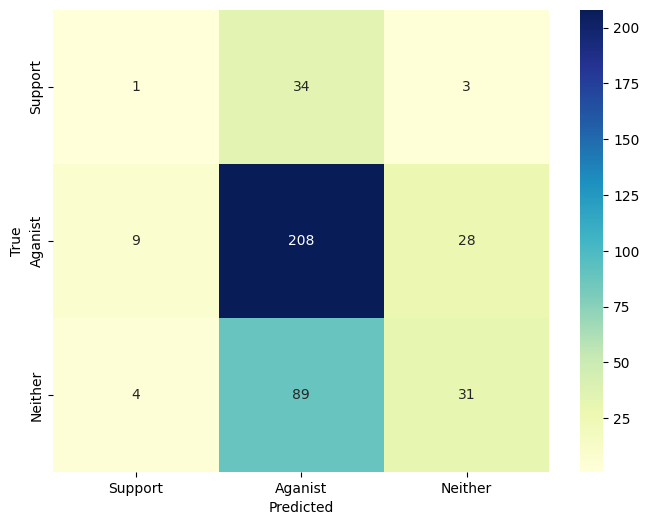

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
# 绘制混淆矩阵热图
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu", xticklabels=['Support', 'Aganist', 'Neither'], yticklabels=['Support', 'Aganist', 'Neither'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()